# Travel Aggregator Analysis

## Introduction

### Overview

This notebook is designed to perform an in-depth analysis of the travel data provided by **MyNextBooking**, an Indian start-up aiming to streamline travel bookings by aggregating prices across major platforms like Yatra, MakeMyTrip (MMT), and Goibibo. The goal of this analysis is to extract actionable insights from historical booking and session data to better understand customer behavior, booking trends, and platform performance.

### Objectives

* Address specific business questions related to bookings, sessions, and customer behavior.
* Provide detailed visualizations and metrics to uncover patterns and trends.
* Deliver actionable insights that can help optimize the platform and improve customer experience.

### Key Questions

This notebook aims to answer the following questions:

1. How many distinct bookings, sessions, and searches are present in the data?
2. How many sessions have more than one booking?
3. Which days of the week see the highest number of bookings, and what is their distribution?
4. What is the total number of bookings and the Gross Booking Value (GBV) for each service name?
5. For customers with multiple bookings, which is the most frequently booked route (from city to city)?
6. Which are the top 3 departure cities with the highest advance bookings (minimum 5 departures)?
7. What is the correlation between numerical columns, and which pair of columns have the highest correlation?
8. For each service name, what is the most commonly used device type for bookings?
9. What are the quarterly trends for bookings by device type?
What are the trends in the overall booking-to-search ratio (oBSR) by:
    * Month of the year
    * Day of the week
    * All available dates (time series plot)

### Datasets

* `Bookings.csv`: Contains detailed information about individual bookings, including customer details, booking time, route information, service name, device type, and Gross Booking Value (GBV).
* `Sessions.csv`: Contains session-level data, including session identifiers, searches performed, session start times, and bookings associated with each session.

### Loading Libraries

In [27]:
import numpy as np # array numerical operations
import pandas as pd # data analysis and manipulation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns

from typing import List, Dict # use type hints 

### Loading the data

In [7]:
# import bookings 
bookings = pd.read_csv('../Data/Bookings.csv')

In [8]:
# preview the data 
bookings.head()

,customer_id,booking_id,from_city,from_country,to_city,to_country,booking_time,device_type_used,INR_Amount,service_name,no_of_passengers,days_to_departure,distance_km
0,customer_259,booking_82,Gurgaon,India,Ahmedabad,India,2020-02-05T16:12:08Z,Desktop,2565.28,MMT,1.0,10.0,747.8
1,customer_303,booking_156,Delhi,India,Brussels,Belgium,2018-11-21T08:21:47Z,Android,23120.00,YATRA,1.0,1.0,6701.5
2,customer_203,booking_99,Devanhalli,India,Frankfurt am Main,Germany,2019-12-16T22:54:58Z,Android,25717.60,YATRA,1.0,32.0,7712.0
3,customer_211,booking_319,Gurgaon,India,Frankfurt am Main,Germany,2021-10-29T12:25:38Z,Desktop,135969.60,GOIBIBO,2.0,69.0,6112.5
4,customer_287,booking_222,Gurgaon,India,Roissy-en-France,France,2020-08-11T16:09:10Z,Android,31791.20,GOIBIBO,1.0,3.0,6570.4


In [9]:
# brief description: Bookings 
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        339 non-null    object 
 1   booking_id         339 non-null    object 
 2   from_city          339 non-null    object 
 3   from_country       339 non-null    object 
 4   to_city            339 non-null    object 
 5   to_country         339 non-null    object 
 6   booking_time       339 non-null    object 
 7   device_type_used   339 non-null    object 
 8   INR_Amount         339 non-null    float64
 9   service_name       339 non-null    object 
 10  no_of_passengers   339 non-null    float64
 11  days_to_departure  339 non-null    float64
 12  distance_km        339 non-null    float64
dtypes: float64(4), object(9)
memory usage: 34.6+ KB


In [10]:
# import sessions
sessions = pd.read_csv('../Data/Sessions.csv')

In [11]:
# preview the data 
sessions.head()

,session_id,search_id,search_time,session_starting_time,booking_id
0,session_322,search_784,2020-01-21T21:35:38.910Z,2020-01-21T21:10:12Z,NaN
1,session_322,search_776,2020-01-21T21:37:37.697Z,2020-01-21T21:10:12Z,NaN
2,session_322,search_623,2020-01-21T21:36:11.392Z,2020-01-21T21:10:12Z,NaN
3,session_322,search_270,2020-01-21T21:16:07.685Z,2020-01-21T21:10:12Z,NaN
4,session_322,search_905,2020-01-21T21:34:55.673Z,2020-01-21T21:10:12Z,NaN


In [12]:
# brief description: Sessions
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   session_id             1497 non-null   object
 1   search_id              1497 non-null   object
 2   search_time            1497 non-null   object
 3   session_starting_time  1497 non-null   object
 4   booking_id             366 non-null    object
dtypes: object(5)
memory usage: 58.6+ KB


## Data Processing

### checking for missing values

In [13]:
def missing_values(data) -> pd.DataFrame:
    """
    checking for missing values in a pandas DataFrame
    
    parameters:
        data pd.DataFrame : Pandas dataframe to check for missing values

    returns:
        missing_df pd.DataFrame: pandas dataframe of columns and their count and percentage of missing values
    """
    # check if dataframe 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a Pandas DataFrame")
    # check if any missing value
    if not data.isnull().values.any():
        return "The DataFrame has no missing values"
    else:
        missing = data.isnull().sum().sort_values(ascending=False)

        missing_per = np.round(((data.isnull().sum() / len(data)).sort_values(ascending=False)), 2)

        missing_df = pd.DataFrame({
            'column' : missing.index,
            'count': missing.values,
            '%': missing_per.values
        })

        # remove values where count is 0: No mising values
        missing_df = missing_df[missing_df['count'] > 0]

        return missing_df

In [14]:
# missing values: Bookings 
missing_values(bookings)

'The DataFrame has no missing values'

In [15]:
# missing values: Sessions
missing_values(sessions)

,column,count,%
0,booking_id,1131,0.76


* Column `booking_id` has 1131 missng values, which accounts for about `76%` of the total data.

In [16]:
# count of unique entries
sessions['booking_id'].nunique()

338

* `338` unique entries out of `366` total entries available.

In [17]:
# count of unique entries: bookings
bookings['booking_id'].nunique()

339

* All entries of the same column in bookings data are unique.

### Check data types

In [18]:
# data types: sessions
sessions.dtypes

session_id               object
search_id                object
search_time              object
session_starting_time    object
booking_id               object
dtype: object

In [19]:
# data types: bookings 
bookings.dtypes

customer_id           object
booking_id            object
from_city             object
from_country          object
to_city               object
to_country            object
booking_time          object
device_type_used      object
INR_Amount           float64
service_name          object
no_of_passengers     float64
days_to_departure    float64
distance_km          float64
dtype: object

* In both datasets, the columns with date data is treated as object and not date-time.

### Convert Timestamps

In [20]:
def convert_to_datetime(data: pd.DataFrame, column: str, date_format: str) -> pd.DataFrame:
    """
    Convert a specifed column in a DataFrame from object to datetime

    parameters: 
        * data(pd.DataFrame): The input DataFrame
        * column (str): Name of the column to be converted to datetime format
        * date_format (str): The date format to use for conversion

    returns 
        pd.DataFrame: DataFrame with the specified column converted to datetime 
    """
    # check if input is DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    # check if column exists in DataFrame 
    if column not in data.columns:
        raise ValueError(f"Column {column} does not exist in the DataFrame")
    
    # attempt to covert column to datetime
    try:
        data[column] = pd.to_datetime(data[column], format=date_format, errors='coerce')
    except Exception as e:
        raise ValueError(f"Error in converting column '{column}' to datetime: {e}")
    
    return data

In [21]:
# convert booking_time: bookings
bookings = convert_to_datetime(bookings, "booking_time", "%Y-%m-%dT%H:%M:%SZ")
bookings.dtypes

customer_id                  object
booking_id                   object
from_city                    object
from_country                 object
to_city                      object
to_country                   object
booking_time         datetime64[ns]
device_type_used             object
INR_Amount                  float64
service_name                 object
no_of_passengers            float64
days_to_departure           float64
distance_km                 float64
dtype: object

In [22]:
# convert search_time & session_starting_time: sessions
columns = ['search_time', 'session_starting_time']

for col in columns:
    sessions = convert_to_datetime(sessions, col, "%Y-%m-%dT%H:%M:%SZ")

sessions.dtypes

session_id                       object
search_id                        object
search_time              datetime64[ns]
session_starting_time    datetime64[ns]
booking_id                       object
dtype: object

### Merge Datasets

In [23]:
# columns: bookings
bookings.columns

Index(['customer_id', 'booking_id', 'from_city', 'from_country', 'to_city',
       'to_country', 'booking_time', 'device_type_used', 'INR_Amount',
       'service_name', 'no_of_passengers', 'days_to_departure', 'distance_km'],
      dtype='object')

In [24]:
# columns: sessions
sessions.columns

Index(['session_id', 'search_id', 'search_time', 'session_starting_time',
       'booking_id'],
      dtype='object')

* **Left Join**: Want all bookings and the corresponding session data (but don't need sessions without bookings), thus using a left join with `Bookings.csv` as the left table.

In [25]:
def left_join(data1: pd.DataFrame, data2: pd.DataFrame, on: str) -> pd.DataFrame:
    """ 
    Perform a left join between two DataFrames on a specified column.

    parameters:
        * data1 (pd.DataFrame): the first dataframe, on the left
        * data2 (pd.DataFrame): the second dataframe 
        * on (str): The column to join on 

    return:
        pd.DataFrame: The resulting DataFrame after the left join

    raises:
        ValueError: if the columns does not exist in the DataFrame 
    """
    # check if input is DataFrame 
    if not isinstance(data1, pd.DataFrame) or not isinstance(data2, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    # check if the columns exist 
    if on not in data1.columns:
        raise ValueError(f"Column '{on}' not in the first dataframe")
    if on not in data2.columns:
        raise ValueError(f"Column '{on}' not in the second dataframe")
    
    # perform left join
    merged_data = pd.merge(data1, data2, on=on, how='left')

    # drop duplicated entries
    merged_data.drop_duplicates(inplace=True, ignore_index=True)

    return merged_data

In [26]:
# merge bookings and sessions
merged_data = left_join(bookings, sessions, on='booking_id')
# brief description: merged_data
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            340 non-null    object        
 1   booking_id             340 non-null    object        
 2   from_city              340 non-null    object        
 3   from_country           340 non-null    object        
 4   to_city                340 non-null    object        
 5   to_country             340 non-null    object        
 6   booking_time           340 non-null    datetime64[ns]
 7   device_type_used       340 non-null    object        
 8   INR_Amount             340 non-null    float64       
 9   service_name           340 non-null    object        
 10  no_of_passengers       340 non-null    float64       
 11  days_to_departure      340 non-null    float64       
 12  distance_km            340 non-null    float64       
 13  sessi

## Analysis Section

### Q1 Count Distinct Bookings, Sessions and Searches

* Use pandas' `nunique()` function to find the unique counts of bookings, sessions and searches.

In [28]:
def unique_counts(data: pd.DataFrame, columns: List[str]) -> Dict[str, int]:
    """
    Retrieve the unique counts for specified columns in a DataFrame.

    parameters:
        data (pd.DataFrame): The input DataFrame 
        columns (List[str]): List of column names to calculate unique counts for.

    returns:
        Dict[str, int]: A dictionary with column names as keys and their unique counts as values

    raise
        ValueError: if column does not exist in the DataFrame
    """
    # check if input is a DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    # validate all the columns exist in the DataFrame
    for col in columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")
        
    # calculate the unique counts for each column 
    unique_counts = {col: data[col].nunique() for col in columns}

    return unique_counts

In [ ]:
# unique bookings
unique_counts(bookings, ['booking_id'])

{'booking_id': 339}

In [30]:
# unique sessions and searches
unique_counts(sessions, ['session_id', 'search_id'])

{'session_id': 331, 'search_id': 1360}

In [31]:
# merged data 
unique_counts(merged_data, ['booking_id', 'session_id', 'search_id'])

{'booking_id': 339, 'session_id': 329, 'search_id': 338}

### Q2 Sessions with Multiple Bookings

* Group by `session_id` and count the number of associated `booking_id`.
* Filter sessions with more than one booking

In [39]:
def group_count_and_filter(data: pd.DataFrame, group_by: List[str], count_column: str, threshold: int) -> pd.Series:
    """ 
    Group a DataFrame by specified columns, count occurrences, and filter rows exceeding a threshold

    Parameters:
        * data (pd.DataFrame): Input DataFrame
        * group_by (List[str]): List of column(s) to group the data by.
        * count_column (str): The column to count occurrences for.
        * threshold (int): The minimum count threshold for filtering

    returns:
        pd.Series: A Series with group counts filtered by the threshold

    raises:
        ValueError: If any grouping columns or count column does not exist in the DataFrame  
    """

    # check if DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a DataFrame")
    
    # validate group by columns
    for col in group_by:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame")
        
    # validate count columns
    if count_column not in data.columns:
        raise ValueError(f"Column '{count_column}' does not exist in the DataFrame")
    
    # group by specified columns and count occurrences
    grouped_data = data.groupby(group_by)[count_column].count().sort_values(ascending=False)

    # filter rows where the count exceeds the threshold
    filtered_data = grouped_data[grouped_data > threshold]

    return filtered_data
    

In [45]:
# sessions data
grouped_sessions = group_count_and_filter(sessions, ['session_id'], 'booking_id', 1)

grouped_sessions

session_id
session_76     3
session_134    3
session_237    2
session_124    2
session_171    2
session_298    2
session_38     2
session_231    2
session_132    2
session_205    2
session_94     2
session_68     2
session_164    2
session_162    2
session_29     2
session_290    2
session_5      2
session_50     2
session_51     2
session_154    2
session_122    2
session_137    2
session_190    2
session_32     2
session_323    2
session_102    2
session_324    2
session_325    2
session_90     2
session_327    2
session_196    2
session_179    2
session_27     2
session_80     2
session_181    2
Name: booking_id, dtype: int64

In [ ]:
# value counts
grouped_sessions.value_counts()

booking_id
2    33
3     2
Name: count, dtype: int64

### Q3 Bookings by Day of the Week

* Extract the day of the week from `booking_time`
* count bookings for each day
* Visualize the distribution using a pie chart

In [47]:
def bookings_by_day(data: pd.DataFrame, datetime_column: str) -> Dict[str, int]:
    """ 
    Count bookings by day of the week from a Datetime column.
    
    Parameters:
        data (pd.DataFrame): The input DataFrame
        datetime_column (str): The name of the datetime column to extract the day of the week from.

    Returns:
        Dict[str, int]: A dictionary with days of the weeks as keys and their booking counts as Values

    Raises:
        ValueError: If the column does not exist in the DataFrame or is not in datetime format
    """
    # check if input DataFrame 
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a DataFrame.")
    # check if the datetime columns does exist
    if datetime_column not in data.columns:
        raise ValueError(f"Column '{datetime_column}' does not exist in the DataFrame.")
    # check if the column is in datetime format 
    if not pd.api.types.is_datetime64_any_dtype(data[datetime_column]):
        raise ValueError(f"Column '{datetime_column}' must be in datetime fortmat.")
    
    # Extract the day of the week and count bookings 
    day_counts = data[datetime_column].dt.day_name().value_counts().to_dict()

    return day_counts

In [49]:
# count bookings for each day 
day_booking_counts = bookings_by_day(bookings, 'booking_time')

day_booking_counts

{'Thursday': 65,
 'Tuesday': 59,
 'Monday': 51,
 'Friday': 51,
 'Saturday': 44,
 'Sunday': 35,
 'Wednesday': 34}

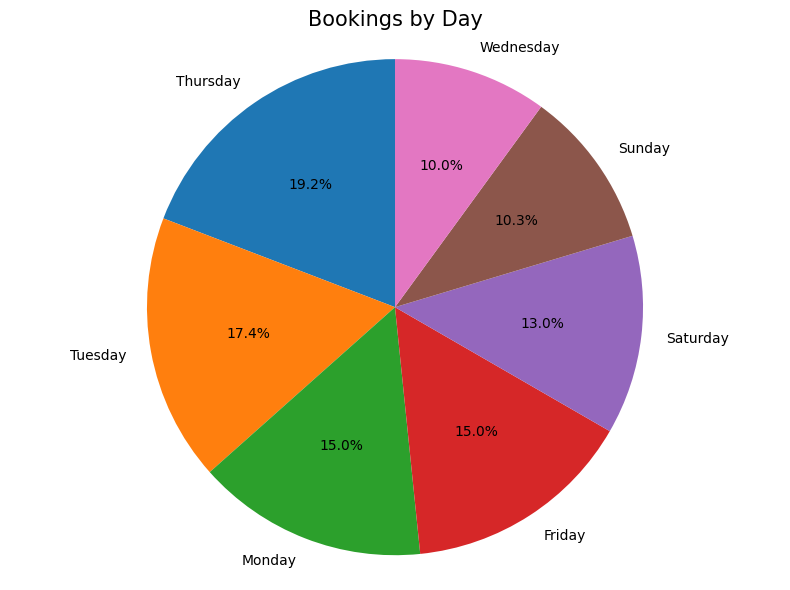

In [59]:
# visualize using a pie chart 
fig, ax = plt.subplots(figsize=(8, 6))

labels = list(day_booking_counts.keys())
sizes = list(day_booking_counts.values())

ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90) # plot the chart

ax.axis('equal') # equal aspect ratio: ensure pie is drawn as a circle

ax.set_title("Bookings by Day", fontsize=15) # label the chart

# show the plot
plt.tight_layout()
plt.show()

# save the image
fig.savefig("../assets/images/bookings.png")